In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
beijing_pm2_5 = fetch_ucirepo(id=381)

X = beijing_pm2_5.data.features
y = beijing_pm2_5.data.targets

In [4]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json

# VIF Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Regression Analysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.ensemble import RandomForestRegressor

# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# ML model
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

In [5]:
from google.colab import drive
drive.mount('/content/drive')

model_path = "/content/drive/My Drive/PM2.5_models/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.concat([X, y], axis=1)

df.head()

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
0,2010,1,1,0,-21,-11.0,1021.0,NW,1.79,0,0,NaN
1,2010,1,1,1,-21,-12.0,1020.0,NW,4.92,0,0,NaN
2,2010,1,1,2,-21,-11.0,1019.0,NW,6.71,0,0,NaN
3,2010,1,1,3,-21,-14.0,1019.0,NW,9.84,0,0,NaN
4,2010,1,1,4,-20,-12.0,1018.0,NW,12.97,0,0,NaN



**Data columns**
- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- pm2.5: PM2.5 concentration (ug/m^3)
- DEWP: Dew Point (â„ƒ)
- TEMP: Temperature (â„ƒ)
- PRES: Pressure (hPa)
- cbwd: Combined wind direction
- Iws: Cumulated wind speed (m/s)
- Is: Cumulated hours of snow
- Ir: Cumulated hours of rain

https://royalsocietypublishing-org.remotexs.ntu.edu.sg/doi/10.1098/rspa.2015.0257


# EDA

## Data Preprocessing

In [7]:
missing_values = df.isna().sum()

missing_values_df_eda = pd.DataFrame({'Feature': missing_values.index, 'Missing Values': missing_values.values})
missing_values_df_eda = missing_values_df_eda.sort_values(by='Missing Values', ascending=False)

missing_values_df_eda

,Feature,Missing Values
11,pm2.5,2067
0,year,0
2,day,0
1,month,0
3,hour,0
4,DEWP,0
6,PRES,0
5,TEMP,0
7,cbwd,0
8,Iws,0


In [8]:
# drop the rows directly -> mess up the order
# first 24 rows have pm2.5 value that is NaN -> discard
# else: forward filling
df = df[24:].fillna(method='ffill')
df['pm2.5'].isna().sum()

<ipython-input-8-fdc79dbbeee5>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df[24:].fillna(method='ffill')


np.int64(0)

In [9]:
missing_values = df.isna().sum()

missing_values_df_eda = pd.DataFrame({'Feature': missing_values.index, 'Missing Values': missing_values.values})
missing_values_df_eda = missing_values_df_eda.sort_values(by='Missing Values', ascending=False)

missing_values_df_eda

,Feature,Missing Values
0,year,0
1,month,0
2,day,0
3,hour,0
4,DEWP,0
5,TEMP,0
6,PRES,0
7,cbwd,0
8,Iws,0
9,Is,0


In [10]:
df['dateTime'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
df.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
df = df.set_index('dateTime')
df.head()

,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
dateTime,,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,SE,1.79,0,0,129.0
2010-01-02 01:00:00,-15,-4.0,1020.0,SE,2.68,0,0,148.0
2010-01-02 02:00:00,-11,-5.0,1021.0,SE,3.57,0,0,159.0
2010-01-02 03:00:00,-7,-5.0,1022.0,SE,5.36,1,0,181.0
2010-01-02 04:00:00,-7,-5.0,1022.0,SE,6.25,2,0,138.0


In [11]:
# Rename columns to be easily recognizable
df = df.rename(columns={'DEWP': 'dew_point',
                        'PRES': 'pressure',
                        'TEMP' : 'temp',
                        'cbwd': 'wind_dir',
                        'Iws': 'wind_speed',
                        'Is':'cum_snow',
                        'Ir': 'cum_rain'
                        })

## ANOVA Testing

In [ ]:
# Prepare Data for Regression
df_model = df.copy()

df_model.head()

,dew_point,temp,pressure,wind_dir,wind_speed,cum_snow,cum_rain,pm2.5
dateTime,,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,SE,1.79,0,0,129.0
2010-01-02 01:00:00,-15,-4.0,1020.0,SE,2.68,0,0,148.0
2010-01-02 02:00:00,-11,-5.0,1021.0,SE,3.57,0,0,159.0
2010-01-02 03:00:00,-7,-5.0,1022.0,SE,5.36,1,0,181.0
2010-01-02 04:00:00,-7,-5.0,1022.0,SE,6.25,2,0,138.0


In [ ]:
df_model.describe()

,dew_point,temp,pressure,wind_speed,cum_snow,cum_rain,pm2.5
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,97.784018
std,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247,91.398542
min,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000,0.000000
25%,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000,29.000000
50%,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000,72.000000
75%,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000,136.000000
max,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000,994.000000


In [ ]:
features_to_scale = ['temp', 'pressure', 'wind_speed', 'cum_snow', 'cum_rain', 'dew_point', 'pm2.5']

scaler = StandardScaler()
df_model_scaled = df_model.copy()
df_model_scaled[features_to_scale] = scaler.fit_transform(df_model[features_to_scale])

df_model_scaled.describe()

,dew_point,temp,pressure,wind_speed,cum_snow,cum_rain,pm2.5
count,4.380000e+04,4.380000e+04,4.380000e+04,4.380000e+04,4.380000e+04,4.380000e+04,4.380000e+04
mean,-2.076472e-17,-8.825006e-17,5.009489e-15,8.954785e-17,-8.435667e-18,3.147153e-17,-4.704507e-17
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-2.898887e+00,-2.580038e+00,-2.477517e+00,-4.686784e-01,-6.937208e-02,-1.377055e-01,-1.069876e+00
25%,-8.197646e-01,-8.577734e-01,-8.224188e-01,-4.418903e-01,-6.937208e-02,-1.377055e-01,-7.525810e-01
50%,1.188454e-02,1.263781e-01,-4.354913e-02,-3.703220e-01,-6.937208e-02,-1.377055e-01,-2.821086e-01
75%,9.128378e-01,8.644917e-01,8.326793e-01,-3.966856e-02,-6.937208e-02,-1.377055e-01,4.181294e-01
max,1.813791e+00,2.422732e+00,2.877212e+00,1.122914e+01,3.543016e+01,2.528188e+01,9.805695e+00


In [ ]:
df_model_scaled

,dew_point,temp,pressure,wind_dir,wind_speed,cum_snow,cum_rain,pm2.5
dateTime,,,,,,,,
2010-01-02 00:00:00,-1.235589,-1.349849,0.345886,SE,-0.441890,-0.069372,-0.137706,0.341541
2010-01-02 01:00:00,-1.166285,-1.349849,0.345886,SE,-0.424098,-0.069372,-0.137706,0.549424
2010-01-02 02:00:00,-0.889069,-1.431862,0.443244,SE,-0.406306,-0.069372,-0.137706,0.669777
2010-01-02 03:00:00,-0.611852,-1.431862,0.540603,SE,-0.370522,1.245425,-0.137706,0.910484
2010-01-02 04:00:00,-0.611852,-1.431862,0.540603,SE,-0.352730,2.560223,-0.137706,0.440012
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,-1.720718,-1.185824,1.708908,NW,4.159670,-0.069372,-0.137706,-0.982347
2014-12-31 20:00:00,-1.651414,-1.267837,1.708908,NW,4.275819,-0.069372,-0.137706,-0.960464
2014-12-31 21:00:00,-1.651414,-1.267837,1.708908,NW,4.374175,-0.069372,-0.137706,-0.960464


R² Score: 0.2150
Adjusted R² Score: 0.2144
Mean Squared Error: 0.8181
                            OLS Regression Results                            
Dep. Variable:                  pm2.5   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     1702.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:36:29   Log-Likelihood:                -45053.
No. Observations:               35040   AIC:                         9.012e+04
Df Residuals:                   35033   BIC:                         9.018e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

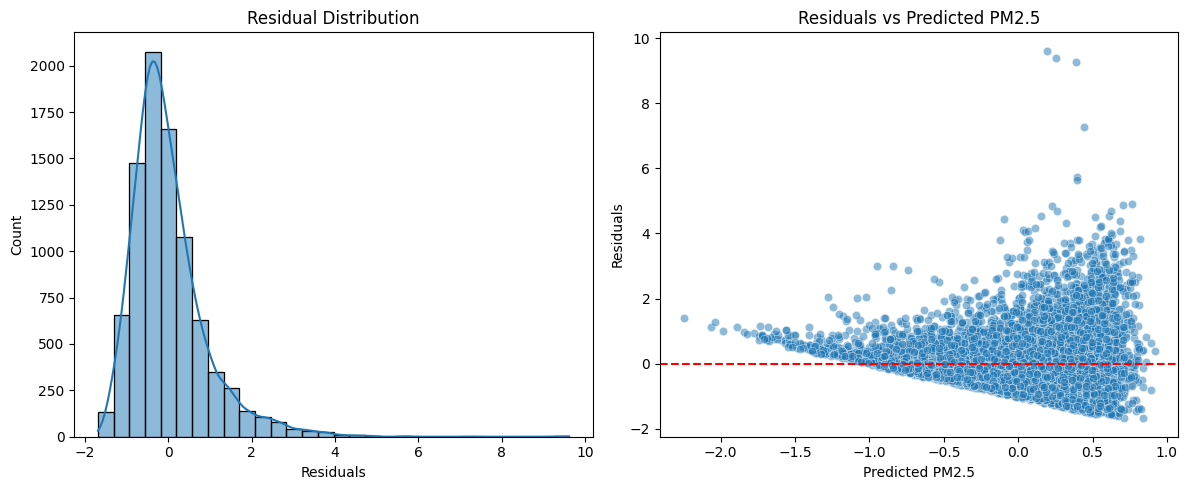

In [ ]:
# Define Independent (X) and Dependent (y) Variables
X = df_model_scaled.drop(columns=['pm2.5', 'wind_dir'])  # Weather features
y = df_model_scaled['pm2.5']  # Target variable

# Split Data into Training & Testing Sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Model Predictions
y_pred = model.predict(X_test)

# Evaluate Model Performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
adj_r2 = 1 - (1-r2) * (len(y_test)-1) / (len(y_test)-X.shape[1]-1)

print(f"R² Score: {r2:.4f}")
print(f"Adjusted R² Score: {adj_r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Run ANOVA (Checking for Variable Significance)
X_const = sm.add_constant(X_train)  # Add intercept for statsmodels
ols_model = sm.OLS(y_train, X_const).fit()
print(ols_model.summary())  # Full regression output

# Residual Analysis (Checking Model Validity)
residuals = y_test - y_pred

plt.figure(figsize=(12,5))

# Residual Histogram
plt.subplot(1,2,1)
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residuals")

# Residuals vs. Predicted Values
plt.subplot(1,2,2)
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted PM2.5")
plt.xlabel("Predicted PM2.5")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

Your regression results indicate a relatively low R² score (0.237), meaning that the model only explains about 23.7% of the variance in PM2.5 concentration based on the given predictors. This suggests that a linear model may not be the best fit for this data, as a significant amount of variance remains unexplained.

The p-values for all independent variables are 0.000, meaning that they are statistically significant. This suggests that the selected features (TEMP, PRES, Iws, Is, Ir, DEWP) do have an impact on PM2.5 levels, but the relationship may not be purely linear.

Residuals plot shows a pattern which implies non-linearity presence in the data.

### Checking multicollinearity

In [ ]:
# Add a constant for intercept
X_const = sm.add_constant(X)

# Compute VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

# Display VIF values
print(vif_data)

      Feature       VIF
0   dew_point  3.849852
1        temp  4.473074
2    pressure  3.493632
3  wind_speed  1.131327
4    cum_snow  1.015717
5    cum_rain  1.028541


VIF measures how much a variable is correlated with others. If VIF > 5 or 10, multicollinearity is present. Base on the VIF values, there is no multicollinearity present in the features except for the wind direction.

It is obvious that multicollinearity will be present in wind direction since they are one-hot encoded. NE will be dropped.

## Checking for feature importance with Decision Tree Regressor

In [ ]:
df_model_scaled_wind = df_model_scaled.copy()

# Encoding wind direction
label_encoder = LabelEncoder()
df_model_scaled_wind["wind_direction"] = label_encoder.fit_transform(df_model_scaled_wind["wind_dir"])
del df_model_scaled_wind['wind_dir']

df_model_scaled_wind.head()

,dew_point,temp,pressure,wind_speed,cum_snow,cum_rain,pm2.5,wind_direction
dateTime,,,,,,,,
2010-01-02 00:00:00,-1.235589,-1.349849,0.345886,-0.441890,-0.069372,-0.137706,0.341541,2
2010-01-02 01:00:00,-1.166285,-1.349849,0.345886,-0.424098,-0.069372,-0.137706,0.549424,2
2010-01-02 02:00:00,-0.889069,-1.431862,0.443244,-0.406306,-0.069372,-0.137706,0.669777,2
2010-01-02 03:00:00,-0.611852,-1.431862,0.540603,-0.370522,1.245425,-0.137706,0.910484,2
2010-01-02 04:00:00,-0.611852,-1.431862,0.540603,-0.352730,2.560223,-0.137706,0.440012,2


Label Encoder chosen over one-hot encoding so that there will not be additional dimensions

In [ ]:
X = df_model_scaled_wind.drop(columns=['pm2.5'])  # Weather features

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    "max_depth": [3, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", None]
}

# Perform grid search optimizing for RMSE
grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=10,
    scoring='neg_root_mean_squared_error'
)
grid_search.fit(X_train, y_train)

# Get the best model
best_tree = grid_search.best_estimator_

# Print best parameters and RMSE score
print(f"Best Parameters for RMSE: {grid_search.best_params_}")
print(f"Best RMSE Score: {-grid_search.best_score_:.4f}")  # Convert to positive RMSE

# Evaluate on test data
y_pred = best_tree.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)  # RMSE

print(f"Test MSE: {mse_test:.4f}")

Best Parameters for RMSE: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best RMSE Score: 0.7986
Test MSE: 0.6681


In [ ]:
best_tree.fit(X_train, y_train)

# Perform cross-validation
mse_scores = -cross_val_score(best_tree, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')

print(f"Cross-validated MSE: {mse_scores.mean():.4f}")

Cross-validated MSE: 0.7986


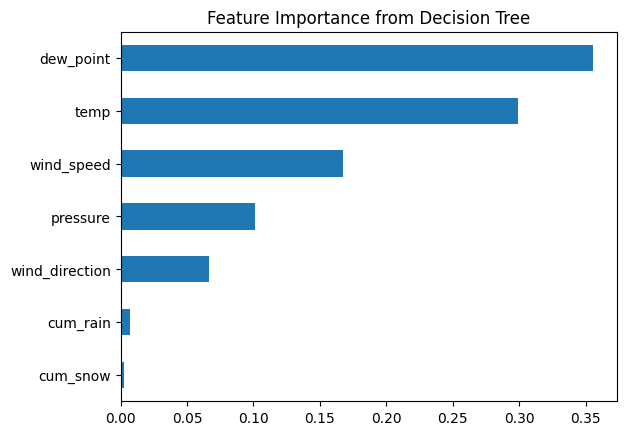

In [ ]:
importance = pd.Series(best_tree.feature_importances_, index=X.columns)
importance.sort_values().plot(kind="barh")
plt.title("Feature Importance from Decision Tree")
plt.show()

Overall, test MSE is performing worser than cross-validated MSE. --> Decision Tree might be overfitting.

# Functions needed for model training

In [14]:
def create_time_lagged_features(df, time_lags):
    """
    Adds time-lagged versions of all numerical columns in the DataFrame.

    Parameters:
    df (pd.DataFrame): Original time-series DataFrame.
    time_lags (list): List of time lags to apply (e.g., [1, 2, 3] for t-1, t-2, t-3).

    Returns:
    pd.DataFrame: DataFrame with time-lagged features.
    """
    df_lagged = df.copy()

    for lag in time_lags:
        lagged_df = df.shift(lag).add_suffix(f" (t-{lag})")  # Shift and rename columns
        df_lagged = pd.concat([df_lagged, lagged_df], axis=1)

    return df_lagged.dropna()  # Drop NaNs caused by shifting

In [15]:
def split_and_standardize_time_lagged(df_lagged, target_column="pm2.5", train_years=[2010, 2011], val_years=[2012], test_years=[2013]):
    """
    Splits the dataset into train, validation, and test sets based on years and applies standardization.

    Parameters:
    - df_lagged (pd.DataFrame): Time-lagged dataset with features and target.
    - target_column (str): Name of the target variable.
    - train_years (list): Years used for training.
    - val_years (list): Years used for validation.
    - test_years (list): Years used for testing.

    Returns:
    - X_train_scaled, y_train: Standardized training set.
    - X_val_scaled, y_val: Standardized validation set.
    - X_test_scaled, y_test: Standardized test set.
    """

    # Extract year column
    df_lagged["year"] = df_lagged.index.year

    # Split data based on years
    df_train = df_lagged[df_lagged["year"].isin(train_years)].drop(columns=["year"])
    df_val = df_lagged[df_lagged["year"].isin(val_years)].drop(columns=["year"])
    df_test = df_lagged[df_lagged["year"].isin(test_years)].drop(columns=["year"])

    # Split into features (X) and target (y)
    X_train, y_train = df_train.drop(columns=[target_column]), df_train[target_column]
    X_val, y_val = df_val.drop(columns=[target_column]), df_val[target_column]
    X_test, y_test = df_test.drop(columns=[target_column]), df_test[target_column]

    # Standardize features using training mean and std
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit on train
    X_val_scaled = scaler.transform(X_val)  # Transform validation
    X_test_scaled = scaler.transform(X_test)  # Transform test

    return X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test

In [45]:
def train_random_forest(X_train, y_train, X_test, y_test, n_estimators=100, cv=5):
    """
    Trains and evaluates a Random Forest model with cross-validation.

    Parameters:
    - X_train, y_train: Training features and labels.
    - X_test, y_test: Test features and labels.
    - n_estimators (int): Number of trees in the forest.
    - cv (int): Number of cross-validation folds.

    Returns:
    - rf_model: Trained Random Forest model.
    - results_df: DataFrame with evaluation metrics.
    """

    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    # Compute evaluation metrics on test set
    mae = mean_absolute_error(y_test, y_pred_rf)
    mse = mean_squared_error(y_test, y_pred_rf)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_rf)

    # Perform cross-validation on the training set
    cv_r2_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="r2")
    cv_rmse_scores = np.sqrt(-cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error"))
    cv_mae_scores = -cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error")

    results = {
        "Model": "Random Forest",
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R² Score": r2,
        "CV R² Mean": np.mean(cv_r2_scores),
        "CV RMSE Mean": np.mean(cv_rmse_scores),
        "CV MAE Mean": np.mean(cv_mae_scores)
    }

    results_df = pd.DataFrame([results])

    return rf_model, results_df

In [ ]:
def train_hybrid_arima_lstm(X_train, y_train, X_val, y_val, X_test, y_test, model_name, arima_order=(3,1,3), epochs=50, batch_size=128):
    """
    Trains a hybrid ARIMA + LSTM model for time series forecasting.

    Parameters:
    - X_train, y_train: Training data
    - X_val, y_val: Validation data
    - X_test, y_test: Testing data
    - model_name (str): Filename to save the trained model
    - arima_order (tuple): Order of the ARIMA model (p, d, q)
    - epochs (int): Number of training epochs
    - batch_size (int): Batch size for training

    Returns:
    - model: The trained LSTM model
    - history: Training history (for plotting loss curves)
    - arima_model: The trained ARIMA model
    """

    # Step 1: Train ARIMA Model
    print("Training ARIMA model...")
    arima_model = ARIMA(y_train, order=arima_order)
    arima_model = arima_model.fit()

    # Step 2: Get ARIMA Predictions (In-Sample)
    arima_train_pred = arima_model.predict(start=0, end=len(y_train)-1)
    arima_val_pred = arima_model.predict(start=len(y_train), end=len(y_train)+len(y_val)-1)
    arima_test_pred = arima_model.predict(start=len(y_train)+len(y_val), end=len(y_train)+len(y_val)+len(y_test)-1)

    # Step 3: Compute Residuals (Difference Between Actual and ARIMA Predictions)
    train_residuals = y_train - arima_train_pred
    val_residuals = y_val - arima_val_pred
    test_residuals = y_test - arima_test_pred

    # Step 4: Define LSTM Model for Residual Forecasting
    print("Training LSTM model on ARIMA residuals...")
    model = keras.Sequential([
        layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(64),
        layers.Dropout(0.2),
        layers.Dense(1)  # Output layer
    ])

    # Compile the Model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-4), loss='mae')

    # Early Stopping Callback
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    # Learning Rate Reduction Callback
    lr_reduced = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001
    )

    # Step 5: Train the LSTM Model on Residuals
    history = model.fit(
        X_train, train_residuals,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, val_residuals),
        callbacks=[early_stopping, lr_reduced]
    )

    with open(model_name + "_training_history.json", "w") as f:
        json.dump(history.history, f)

    # Save the Trained Model
    model.save(model_name + ".keras")
    print(f"Model saved as: {model_name}")

    return model, history  # Return both ARIMA & LSTM models

In [ ]:
def resample_and_plot_predictions(model,X_test, y_test):
    """
    Resamples hourly predictions to daily averages and plots actual vs. predicted PM2.5 levels.

    Parameters:
    - predictions_df (pd.DataFrame): DataFrame containing 'Actual' and 'Predicted' PM2.5 values.

    Returns:
    - predictions_resampled (pd.DataFrame): Resampled DataFrame with daily averages.
    """

    # Make Predictions
    y_pred = model.predict(X_test)

    y_test = y_test.reshape(-1, 1)

    # Convert to DataFrame for comparison
    predictions_df = pd.DataFrame({
        "Actual": y_test.flatten(),
        "Predicted": y_pred.flatten()
    })

    # Create an index assuming each row represents 1 hour
    predictions_df["Hour_Index"] = range(len(predictions_df))

    # Resample to daily intervals (every 24 hours)
    predictions_resampled = predictions_df.groupby(predictions_df["Hour_Index"] // 24).mean()

    # Drop the index column
    predictions_resampled.drop(columns=["Hour_Index"], inplace=True)

    # Plot the resampled data
    plt.figure(figsize=(20, 8))
    plt.plot(predictions_resampled.index, predictions_resampled["Actual"], label="Actual PM2.5", alpha=0.7)
    plt.plot(predictions_resampled.index, predictions_resampled["Predicted"], label="Predicted PM2.5", alpha=0.7)

    plt.xlabel("Days")
    plt.ylabel("PM2.5")
    plt.title("PCA-ARIMA-LSTM Predictions vs. Actual (Resampled to Daily)")
    plt.legend()
    plt.show()

In [ ]:
def train_xgboost(X_train, y_train, X_val, y_val, X_test, y_test, n_estimators=100, learning_rate=0.05, cv=5):
    """
    Trains and evaluates an XGBoost model with early stopping and cross-validation.

    Parameters:
    - X_train, y_train: Training features and labels.
    - X_val, y_val: Validation features and labels.
    - X_test, y_test: Test features and labels.
    - n_estimators (int): Number of trees in the model.
    - learning_rate (float): Learning rate for XGBoost.
    - cv (int): Number of cross-validation folds.
    - early_stopping_rounds (int): Number of rounds without improvement before stopping training.

    Returns:
    - xgb_model: Trained XGBoost model.
    - results_df: DataFrame with evaluation metrics.
    """

    xgb_model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    # Train model with early stopping
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    y_pred_xgb = xgb_model.predict(X_test)

    # Compute evaluation metrics on test set
    mae = mean_absolute_error(y_test, y_pred_xgb)
    mse = mean_squared_error(y_test, y_pred_xgb)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_xgb)

    # Perform cross-validation on training set
    cv_r2_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring="r2")
    cv_rmse_scores = np.sqrt(-cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error"))
    cv_mae_scores = -cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error")

    results = {
        "Model": "XGBoost",
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R² Score": r2,
        "CV R² Mean": np.mean(cv_r2_scores),
        "CV RMSE Mean": np.mean(cv_rmse_scores),
        "CV MAE Mean": np.mean(cv_mae_scores)

    }

    results_df = pd.DataFrame([results])

    return xgb_model, results_df

In [ ]:
def create_sequences(df, seq_len, delay):
    """
    Create sequences from a Pandas DataFrame while maintaining datetime indices.

    Parameters:
    - df (pd.DataFrame): The input time-series data.
    - seq_len (int): Number of past observations to consider.
    - delay (int): How far ahead to predict.

    Returns:
    - np.array: A NumPy array containing sequences as 1D flattened arrays.
    """
    return np.array([df.iloc[i : i + seq_len + delay].values for i in range(len(df) - seq_len - delay)])

In [ ]:
def split_and_standardize(df_sequences, seq_len, delay, train_ratio=0.6, val_ratio=0.2):
    """
    Splits the dataset into train, validation, and test sets based on a given ratio and applies standardization.

    Parameters:
    - df_sequences (np.array): NumPy array containing sequences with datetime indices.
    - seq_len (int): Number of past observations to consider.
    - delay (int): How far ahead to predict.
    - train_ratio (float): Proportion of data to be used for training (default is 60%).
    - val_ratio (float): Proportion of data to be used for validation (default is 20%).
      The test set will take the remaining portion.\

    Returns:
    - train_x, train_y: Standardized training set.
    - val_x, val_y: Standardized validation set.
    - test_x, test_y: Standardized test set.
    """

    # Ensure split ratios leave room for the test set
    test_ratio = 1.0 - (train_ratio + val_ratio)
    if test_ratio <= 0:
        raise ValueError("Invalid split ratios! Sum of train and val ratios must be < 1.0")

    np.random.shuffle(df_sequences)

    x = df_sequences[:, :seq_len, :]
    y = df_sequences[:, -delay, 0]

    # Compute split indices
    total_samples = y.shape[0]
    train_split = int(total_samples * train_ratio)
    val_split = train_split + int(total_samples * val_ratio)  # Ensure test data remains

    # Train split
    train_x, train_y = x[:train_split], y[:train_split]

    # Validation split
    val_x, val_y = x[train_split:val_split], y[train_split:val_split]

    # Test split
    test_x, test_y = x[val_split:], y[val_split:]

    # Compute mean & std from training set
    mean, std = train_x.mean(axis=0), train_x.std(axis=0)

    # Standardize using training set mean & std
    train_x = (train_x - mean) / std
    val_x = (val_x - mean) / std
    test_x = (test_x - mean) / std

    print(f"Train: {train_x.shape}, Validation: {val_x.shape}, Test: {test_x.shape}")

    return train_x, train_y, val_x, val_y, test_x, test_y

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Evaluates a trained model on training, validation, and test datasets with metrics and visualization.

    Parameters:
    - model: Trained machine learning model.
    - X_train, y_train: Training data and labels.
    - X_val, y_val: Validation data and labels.
    - X_test, y_test: Test data and labels.

    Returns:
    - results_df: DataFrame containing MAE, MSE, RMSE, and R² for train, validation & test sets.
    """

    # Compute Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Compute Metrics for Training Set
    train_results = {
        "Dataset": "Training",
        "MAE": mean_absolute_error(y_train, y_train_pred),
        "MSE": mean_squared_error(y_train, y_train_pred),
        "RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "R² Score": r2_score(y_train, y_train_pred),
    }

    # Compute Metrics for Validation Set
    val_results = {
        "Dataset": "Validation",
        "MAE": mean_absolute_error(y_val, y_val_pred),
        "MSE": mean_squared_error(y_val, y_val_pred),
        "RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred)),
        "R² Score": r2_score(y_val, y_val_pred),
    }

    # Compute Metrics for Test Set
    test_results = {
        "Dataset": "Test",
        "MAE": mean_absolute_error(y_test, y_test_pred),
        "MSE": mean_squared_error(y_test, y_test_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "R² Score": r2_score(y_test, y_test_pred),
    }

    # Create a DataFrame for all metrics
    results_df = pd.DataFrame([train_results, val_results, test_results])

    # Scatter Plot - Actual vs. Predicted for Test, Validation, and Train Sets
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Test Set Plot
    axes[0].scatter(y_test, y_test_pred, alpha=0.5)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")  # Ideal line
    axes[0].set_xlabel("Actual PM2.5")
    axes[0].set_ylabel("Predicted PM2.5")
    axes[0].set_title("Test Set: Actual vs. Predicted")

    # Validation Set Plot
    axes[1].scatter(y_val, y_val_pred, alpha=0.5)
    axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red")  # Ideal line
    axes[1].set_xlabel("Actual PM2.5")
    axes[1].set_ylabel("Predicted PM2.5")
    axes[1].set_title("Validation Set: Actual vs. Predicted")

    # Train Set Plot
    axes[2].scatter(y_train, y_train_pred, alpha=0.5)
    axes[2].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color="red")  # Ideal line
    axes[2].set_xlabel("Actual PM2.5")
    axes[2].set_ylabel("Predicted PM2.5")
    axes[2].set_title("Train Set: Actual vs. Predicted")

    plt.tight_layout()
    plt.show()

    return results_df  # Returning DataFrame instead of dictionary

# Static model for tabular dataset

In [12]:
df_time_lagged = df.copy()
df_time_lagged.head()

,dew_point,temp,pressure,wind_dir,wind_speed,cum_snow,cum_rain,pm2.5
dateTime,,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,SE,1.79,0,0,129.0
2010-01-02 01:00:00,-15,-4.0,1020.0,SE,2.68,0,0,148.0
2010-01-02 02:00:00,-11,-5.0,1021.0,SE,3.57,0,0,159.0
2010-01-02 03:00:00,-7,-5.0,1022.0,SE,5.36,1,0,181.0
2010-01-02 04:00:00,-7,-5.0,1022.0,SE,6.25,2,0,138.0


In [13]:
df_time_lagged = df_time_lagged.join(pd.get_dummies(df['wind_dir']).astype('int')) # one-hot encoding
del df_time_lagged['wind_dir']
df_time_lagged.head()

,dew_point,temp,pressure,wind_speed,cum_snow,cum_rain,pm2.5,NE,NW,SE,cv
dateTime,,,,,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,1.79,0,0,129.0,0,0,1,0
2010-01-02 01:00:00,-15,-4.0,1020.0,2.68,0,0,148.0,0,0,1,0
2010-01-02 02:00:00,-11,-5.0,1021.0,3.57,0,0,159.0,0,0,1,0
2010-01-02 03:00:00,-7,-5.0,1022.0,5.36,1,0,181.0,0,0,1,0
2010-01-02 04:00:00,-7,-5.0,1022.0,6.25,2,0,138.0,0,0,1,0


In [16]:
# Apply function to create lags for all numerical features with t-1 and t-2
df_lagged = create_time_lagged_features(df_time_lagged, time_lags=[1, 2])

In [17]:
# Extract Features (X) and Target (y)
X_train, y_train, X_val, y_val, X_test, y_test = split_and_standardize_time_lagged(df_lagged)

print(f"Training Set: {X_train.shape}, {y_train.shape}")
print(f"Validation Set: {X_val.shape}, {y_val.shape}")
print(f"Testing Set: {X_test.shape}, {y_test.shape}")

Training Set: (17494, 32), (17494,)
Validation Set: (8784, 32), (8784,)
Testing Set: (8760, 32), (8760,)


## Random Forest

In [46]:
rf_model, rf_results = train_random_forest(X_train, y_train, X_test, y_test, n_estimators=100, cv=5)

## XgBoost

In [48]:
xgb_model, xgb_results = train_xgboost(X_train, y_train, X_val, y_val, X_test, y_test, n_estimators=100, learning_rate=0.05, cv=5)

## Comparing XgBoost and Random Forest performance

In [49]:
# Combine results into a single DataFrame
results_df = pd.concat([rf_results, xgb_results], ignore_index=True)

results_df

,Model,MAE,MSE,RMSE,R² Score,CV R² Mean,CV RMSE Mean,CV MAE Mean
0,Random Forest,13.700027,682.464516,26.124022,0.928844,0.899180,27.634744,14.221538
1,XGBoost,13.326582,732.404803,27.062978,0.923637,0.912531,25.762243,13.606027


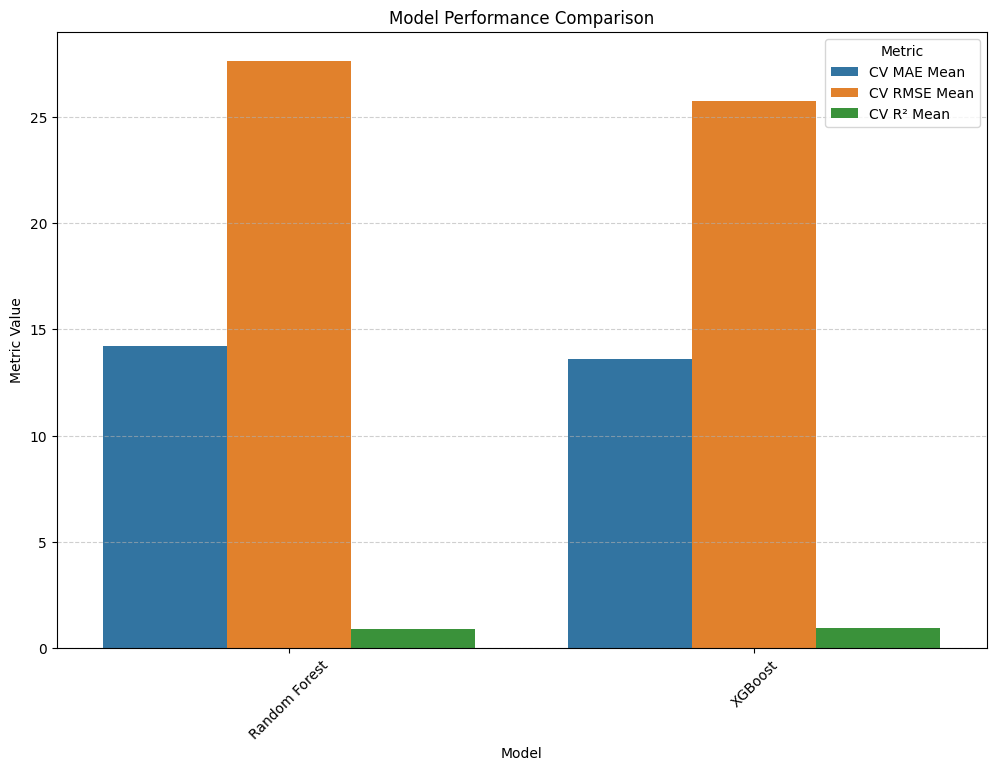

In [50]:
metrics = ["CV MAE Mean","CV RMSE Mean","CV R² Mean"]
results_melted = results_df.melt(id_vars=["Model"], value_vars=metrics, var_name="Metric", value_name="Value")

# Create a grid of subplots for different metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=results_melted, x="Model", y="Value", hue="Metric")

# Customize plot
plt.title("Model Performance Comparison")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show plot
plt.show()

## LSTM

In [27]:
timesteps = 2  # We have t-1 and t-2 features
num_features = X_train.shape[1] // timesteps  # Ensure division is valid

# Reshape into (samples, timesteps, features)
X_train_reshaped = X_train.reshape(-1, timesteps, num_features)
X_val_reshaped = X_val.reshape(-1, timesteps, num_features)
X_test_reshaped = X_test.reshape(-1, timesteps, num_features)

print(f"Final Shape - X_train: {X_train_reshaped.shape}, X_val: {X_val_reshaped.shape}, X_test: {X_test_reshaped.shape}")

Final Shape - X_train: (17494, 2, 16), X_val: (8784, 2, 16), X_test: (8760, 2, 16)


In [28]:
# model_time_lagged, history_time_lagged = train_lstm(
#     X_train_reshaped, y_train,
#     X_val_reshaped, y_val,
#     X_test_reshaped, y_test,
#     model_name="lstm_time_lagged_2_forecast_pm25",
#     epochs=500,
#     batch_size=128
# )

In [29]:
# Load the trained model
model_time_lagged = load_model(model_path + "lstm_time_lagged_2_forecast_pm25.keras")

# Load Training History
with open(model_path+"lstm_time_lagged_2_forecast_pm25_training_history.json", "r") as f:
    history_dict = json.load(f)

# Print summary to confirm it loaded correctly
model_time_lagged.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 2, 32)               │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 2, 32)               │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,837 (268.90 KB)

 Trainable params: 22,945 (89.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,892 (179.27 KB)

In [30]:
# Get Number of Epochs Run
num_epochs = len(history_dict["loss"])
print(f"Total epochs run: {num_epochs}")

Total epochs run: 345


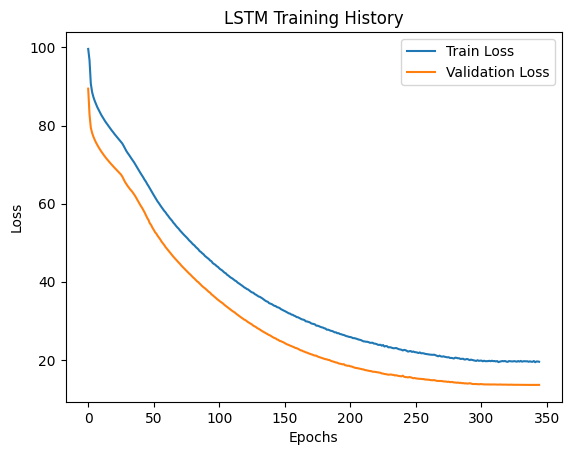

In [31]:
plt.plot(history_dict["loss"], label="Train Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM Training History")
plt.show()

547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


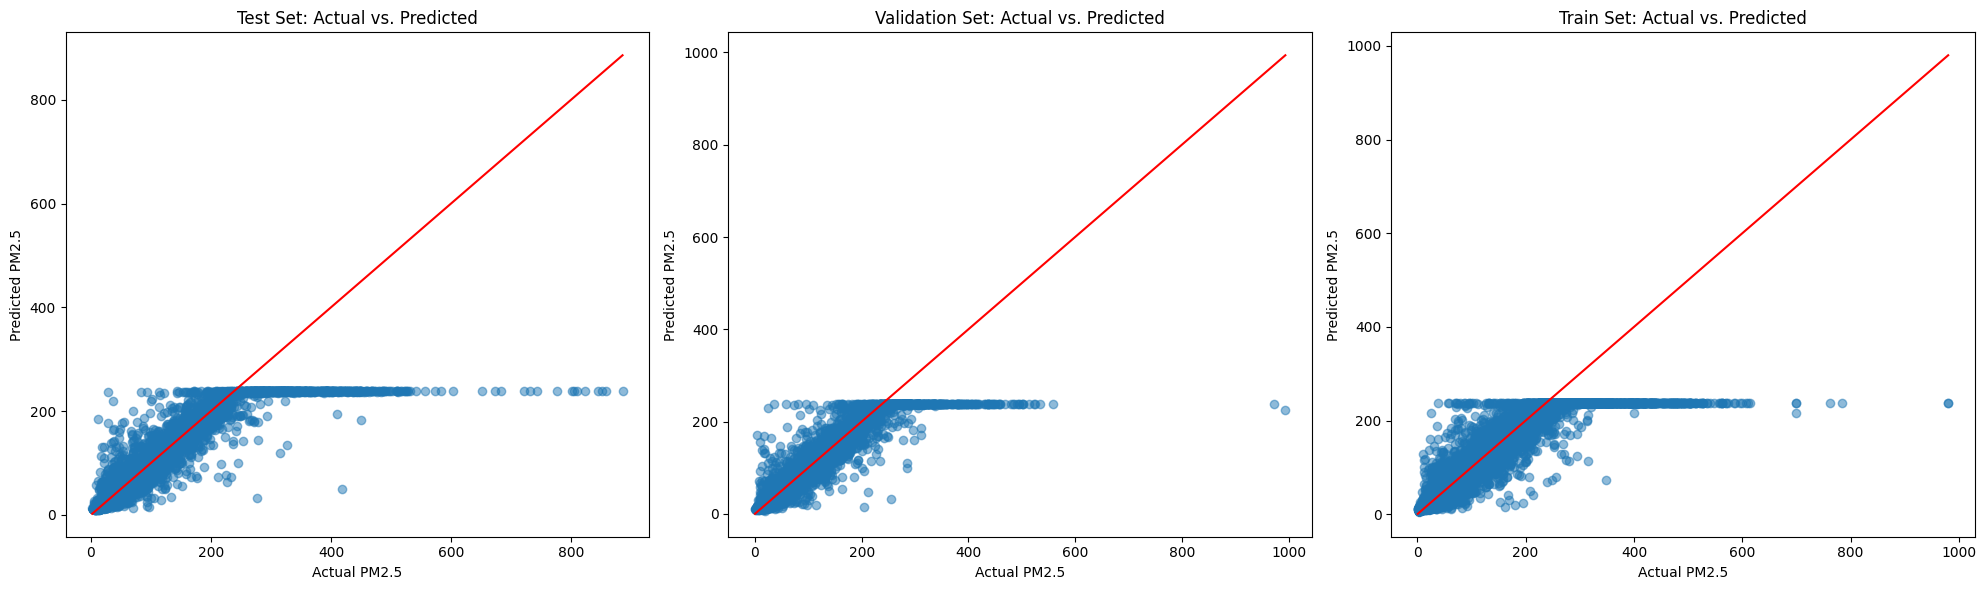

,Dataset,MAE,MSE,RMSE,R² Score
0,Training,16.961486,1479.141434,38.459608,0.823161
1,Validation,13.588502,909.224520,30.153350,0.861459
2,Test,19.004417,2070.503839,45.502789,0.784121


In [32]:
metrics = evaluate_model(model_time_lagged, X_train_reshaped, y_train, X_val_reshaped, y_val, X_test_reshaped, y_test)
metrics

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


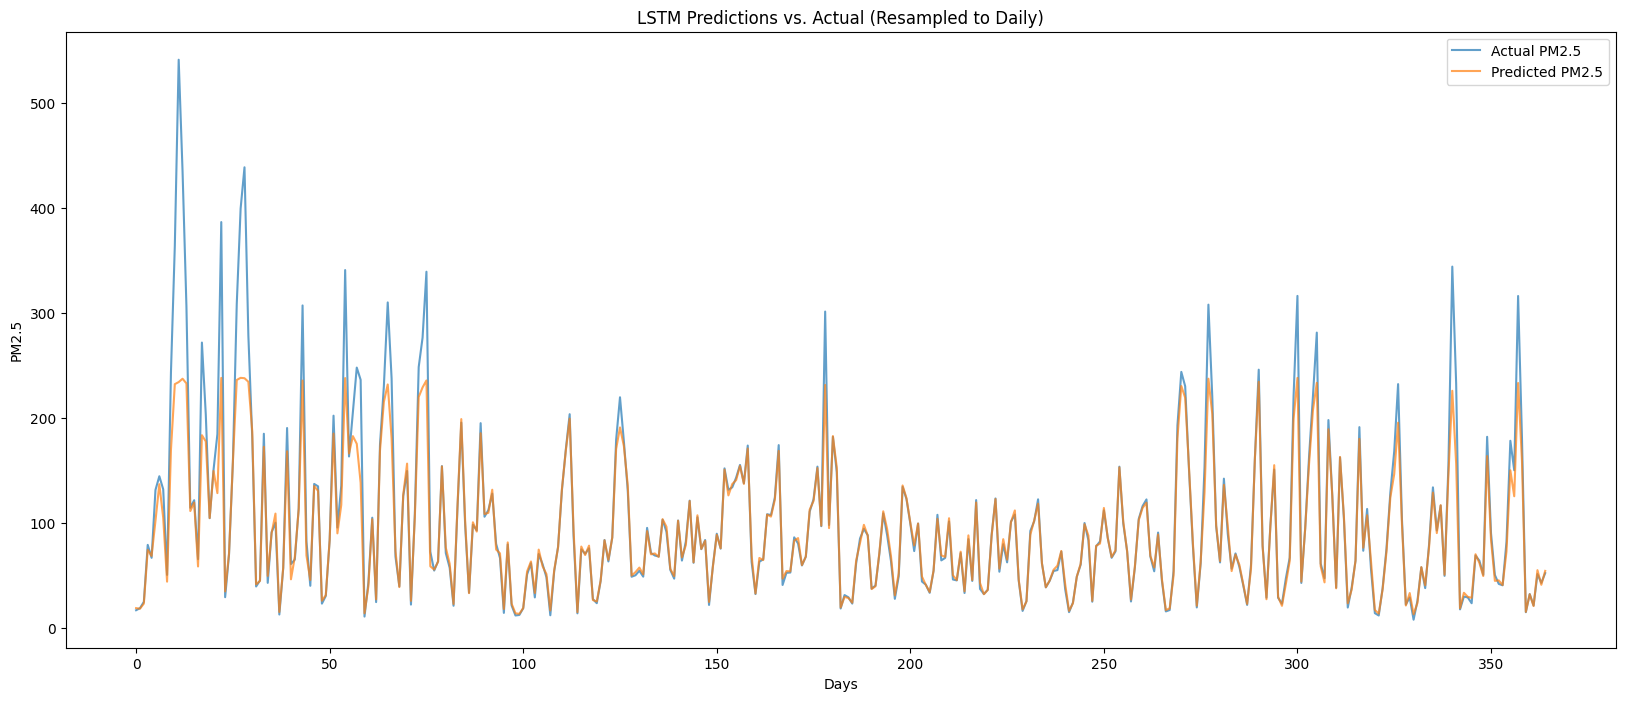

,Actual,Predicted
Hour_Index,,
0,16.500000,18.520956
1,18.458333,17.955177
2,24.500000,22.816698
3,78.791667,74.067101
4,66.416667,68.178841
...,...,...
360,31.916667,31.740158
361,20.958333,20.462074
362,50.958333,54.698528


In [33]:
resample_and_plot_predictions(model_time_lagged, X_test_reshaped, y_test)

# Dynamic model for sequential data

## PCA + LSTM for sequential data

In [ ]:
df_LSTM = df.copy()
df_LSTM.head()

,dew_point,temp,pressure,wind_dir,wind_speed,cum_snow,cum_rain,pm2.5
dateTime,,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,SE,1.79,0,0,129.0
2010-01-02 01:00:00,-15,-4.0,1020.0,SE,2.68,0,0,148.0
2010-01-02 02:00:00,-11,-5.0,1021.0,SE,3.57,0,0,159.0
2010-01-02 03:00:00,-7,-5.0,1022.0,SE,5.36,1,0,181.0
2010-01-02 04:00:00,-7,-5.0,1022.0,SE,6.25,2,0,138.0


In [ ]:
df_LSTM = df_LSTM.join(pd.get_dummies(df['wind_dir']).astype('int')) # one-hot encoding
del df_LSTM['wind_dir']
df_LSTM.head()

,dew_point,temp,pressure,wind_speed,cum_snow,cum_rain,pm2.5,NE,NW,SE,cv
dateTime,,,,,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,1.79,0,0,129.0,0,0,1,0
2010-01-02 01:00:00,-15,-4.0,1020.0,2.68,0,0,148.0,0,0,1,0
2010-01-02 02:00:00,-11,-5.0,1021.0,3.57,0,0,159.0,0,0,1,0
2010-01-02 03:00:00,-7,-5.0,1022.0,5.36,1,0,181.0,0,0,1,0
2010-01-02 04:00:00,-7,-5.0,1022.0,6.25,2,0,138.0,0,0,1,0


In [ ]:
TIMESTEPS = 7 * 24  # Using 7 days to predict next day
DELAY = 1 * 24

## LSTM Without PCA

In [ ]:
df_LSTM_7d = df_LSTM.copy()
df_LSTM_7d.head()

,dew_point,temp,pressure,wind_speed,cum_snow,cum_rain,pm2.5,NE,NW,SE,cv
dateTime,,,,,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,1.79,0,0,129.0,0,0,1,0
2010-01-02 01:00:00,-15,-4.0,1020.0,2.68,0,0,148.0,0,0,1,0
2010-01-02 02:00:00,-11,-5.0,1021.0,3.57,0,0,159.0,0,0,1,0
2010-01-02 03:00:00,-7,-5.0,1022.0,5.36,1,0,181.0,0,0,1,0
2010-01-02 04:00:00,-7,-5.0,1022.0,6.25,2,0,138.0,0,0,1,0


In [ ]:
# Create sequences first
df_LSTM_7d_seq = create_sequences(df_LSTM_7d, TIMESTEPS, DELAY)

df_LSTM_7d_seq.shape

(43608, 192, 11)

In [ ]:
# Split & standardize the dataset"
X_train, y_train, X_val, y_val, X_test, y_test = split_and_standardize(df_LSTM_7d_seq, TIMESTEPS, DELAY)

In [ ]:
# model_7d, history_7d = train_lstm(
#     X_train, y_train,
#     X_val, y_val,
#     X_test, y_test,
#     model_name="lstm_7d_input_1d_forecast_pm25",
#     epochs=100,
#     batch_size=128
# )

In [ ]:
# Load the trained model
model_7d = load_model(model_path + "lstm_7d_input_1d_forecast_pm25.keras")

# Load Training History
with open(model_path + "lstm_7d_input_1d_forecast_pm25_training_history.json", "r") as f:
    history_dict = json.load(f)

# Print summary to confirm it loaded correctly
model_7d.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 168, 32)             │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 168, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 168, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 168, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,917 (261.40 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,612 (174.27 KB)

In [ ]:
# Get Number of Epochs Run
num_epochs = len(history_dict["loss"])
print(f"Total epochs run: {num_epochs}")

Total epochs run: 86


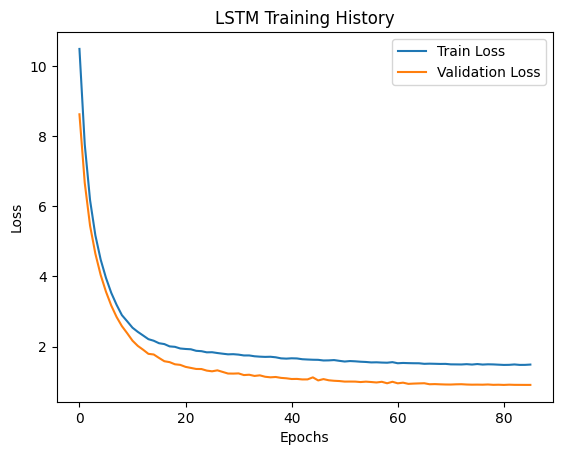

In [ ]:
plt.plot(history_dict["loss"], label="Train Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM Training History")
plt.show()

818/818 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step


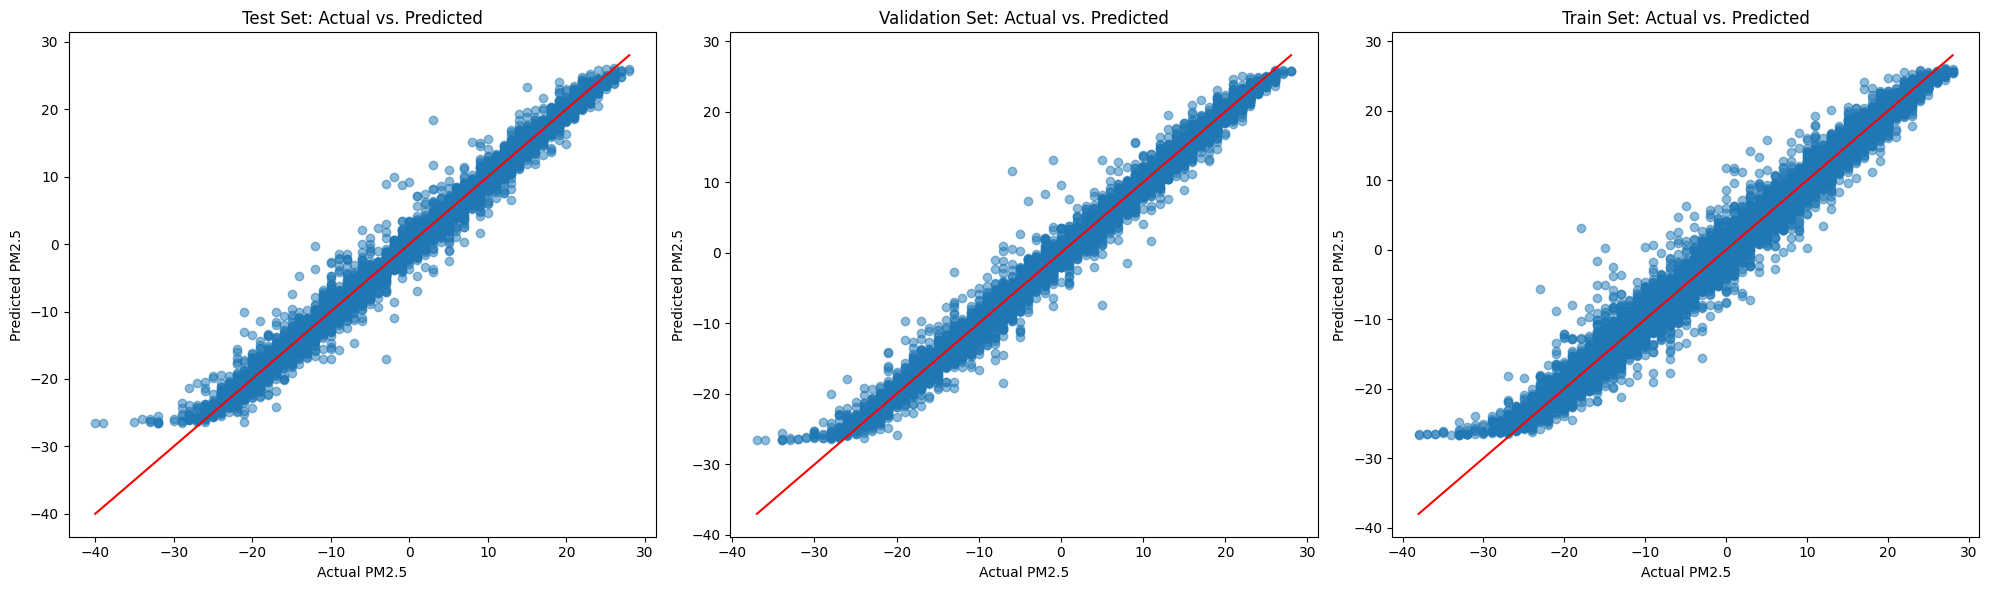

,Dataset,MAE,MSE,RMSE,R² Score
0,Training,0.914604,1.866523,1.366208,0.990980
1,Validation,0.919882,1.875834,1.369611,0.990977
2,Test,0.911046,1.913522,1.383301,0.990742


In [ ]:
metrics_without_pca = evaluate_model(model_7d, X_train, y_train, X_val, y_val, X_test, y_test)
metrics_without_pca

273/273 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step


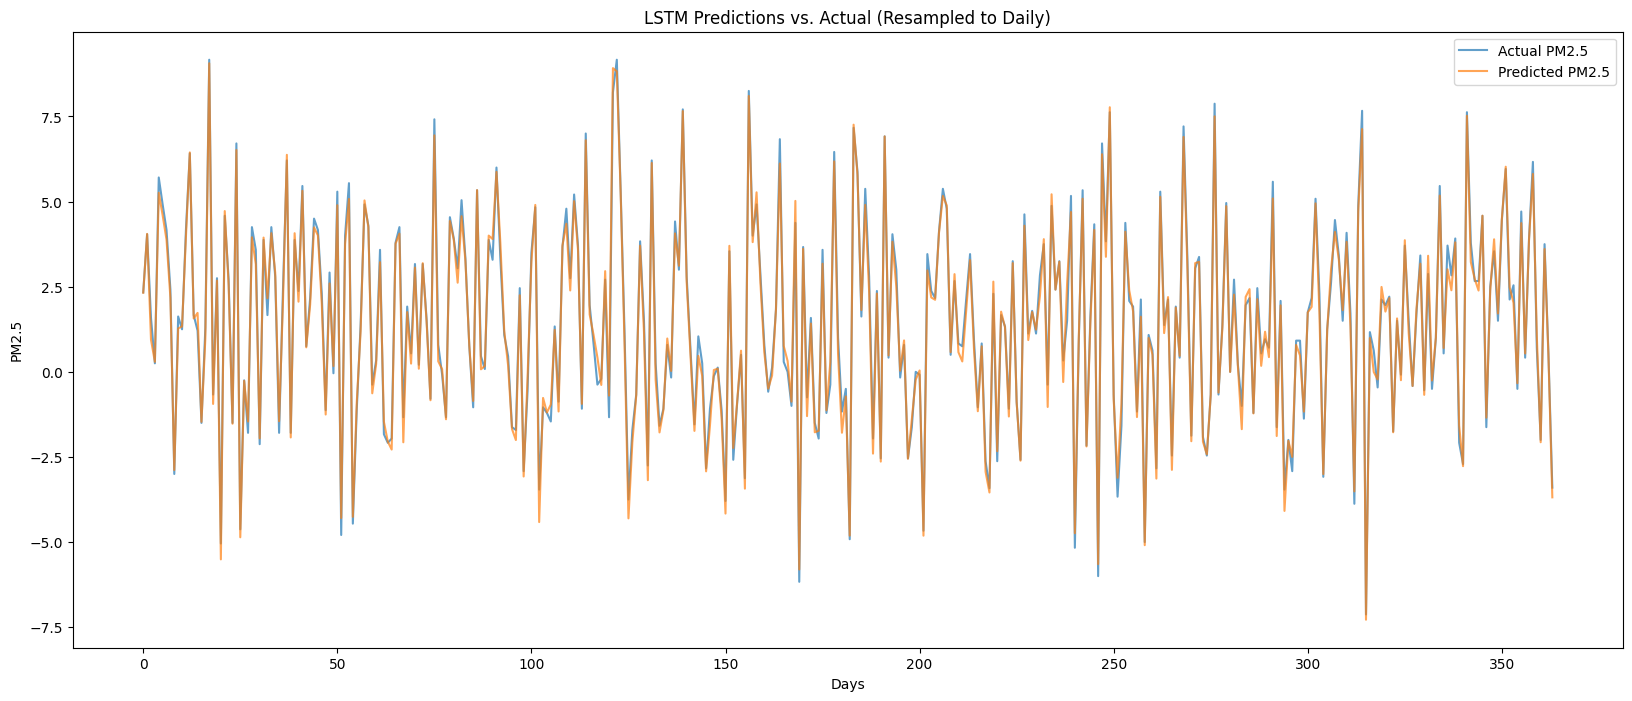

In [ ]:
resample_and_plot_predictions(model_7d, X_test, y_test)

## LSTM with PCA
- PCA is sensitive to the scale of the features because it finds directions of maximum variance. If features have different scales (e.g., pressure in hPa, wind speed in m/s, temperature in °C), PCA will be dominated by large-magnitude features, leading to incorrect principal components.

In [ ]:
df_pca = df_LSTM.copy()

X = df_pca.drop(columns=['pm2.5'])  # Features
y = df_pca['pm2.5'].values  # Target variable

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale features

# Step 2: Apply PCA
pca = PCA(n_components=0.95)  #  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)  # Reduce dimensionality

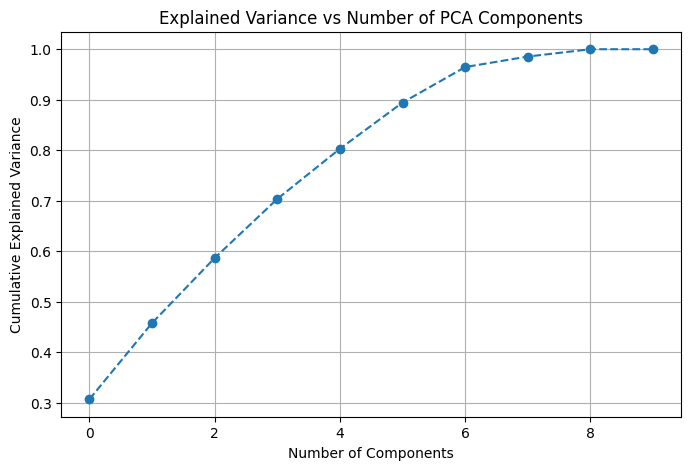

In [ ]:
# Fit PCA without reducing components first
pca_full = PCA().fit(X_scaled)

# Plot variance explained
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs Number of PCA Components")
plt.grid()
plt.show()

- The first few components (PC1, PC2, etc.) explain most of the variance.
- Around 6 components capture nearly 95%-99% of variance, meaning you can reduce dimensionality significantly.
- After PC6, the additional variance explained is small, so keeping more than 6 components may not add much value.
- Elbow Point (~PC4-6): This is where adding more components has diminishing returns.

### Evaluate LSTM with PCA with 4, 5 and 6 components

In [ ]:
pca_components = [5, 6, 7]

# Dictionary to store results
results = {}

for n_comp in pca_components:
    # Apply PCA
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_scaled)  # Transform the scaled data

    # Generate sequences
    df_LSTM_seq = create_sequences(X_pca, TIMESTEPS, DELAY)

    # Split & standardize dataset
    X_train, y_train, X_val, y_val, X_test, y_test = split_and_standardize(df_LSTM_seq, TIMESTEPS, DELAY)

    # Train model
    model_name = f"lstm_7d_pca_{n_comp}_forecast_pm25"
    model_pca, history_pca = train_lstm(
        X_train, y_train,
        X_val, y_val,
        X_test, y_test,
        model_name=model_name,
        epochs=100,
        batch_size=128
    )

    # Evaluate model
    metrics = evaluate_model(model_pca, X_train, y_train, X_val, y_val, X_test, y_test)
    results[n_comp] = metrics  # Store results

    # Plot predictions
    print(f"\nPlotting results for PCA Components: {n_comp}\n")
    resample_and_plot_predictions(model_pca, X_test, y_test)

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 1.0114 - val_loss: 0.5590 - learning_rate: 2.0000e-04
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.5736 - val_loss: 0.5134 - learning_rate: 2.0000e-04
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.5368 - val_loss: 0.4790 - learning_rate: 2.0000e-04
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.5106 - val_loss: 0.4428 - learning_rate: 2.0000e-04
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.4697 - val_loss: 0.3950 - learning_rate: 2.0000e-04
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.4308 - val_loss: 0.3644 - learning_rate: 2.0000e-04
Epoch 7/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.4100 - val_loss: 0.3503 - learning_rate: 2.0000e-04
Epoch 8/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.4014 - val_loss: 0.3402 - learning_rate: 2.0000e-04
Epoch 9/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.3918 - 

#### Evaluate PCA = 5 model

In [ ]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)  # Transform the scaled data

# Generate sequences
df_LSTM_seq = create_sequences(X_pca, TIMESTEPS, DELAY)

# Split & standardize dataset
X_train, y_train, X_val, y_val, X_test, y_test = split_and_standardize(df_LSTM_seq, TIMESTEPS, DELAY)

In [ ]:
# # Load the trained model
# model_pca_5 = load_model(model_path + "lstm_7d_pca_5_forecast_pm25.keras")

# # Load Training History
# with open(model_path + "lstm_7d_pca_5_forecast_pm25_training_history.json", "r") as f:
#     history_dict = json.load(f)

# # Print summary to confirm it loaded correctly
# model_pca_5.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 168, 32)             │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 168, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 168, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 168, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,613 (252.40 KB)

 Trainable params: 21,537 (84.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,076 (168.27 KB)

In [ ]:
# Get Number of Epochs Run
num_epochs = len(history_dict["loss"])
print(f"Total epochs run: {num_epochs}")

Total epochs run: 51


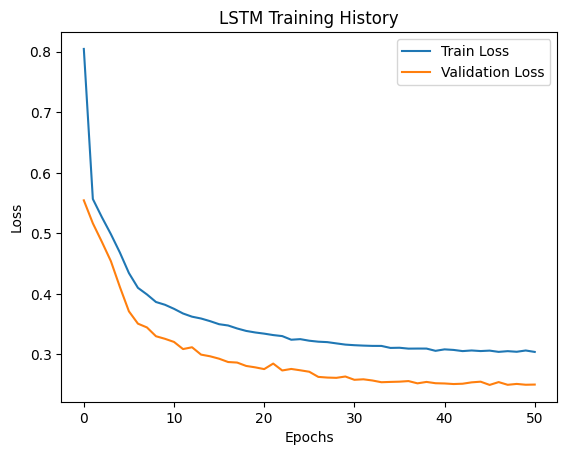

In [ ]:
plt.plot(history_dict["loss"], label="Train Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM Training History")
plt.show()

818/818 ━━━━━━━━━━━━━━━━━━━━ 71s 86ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step


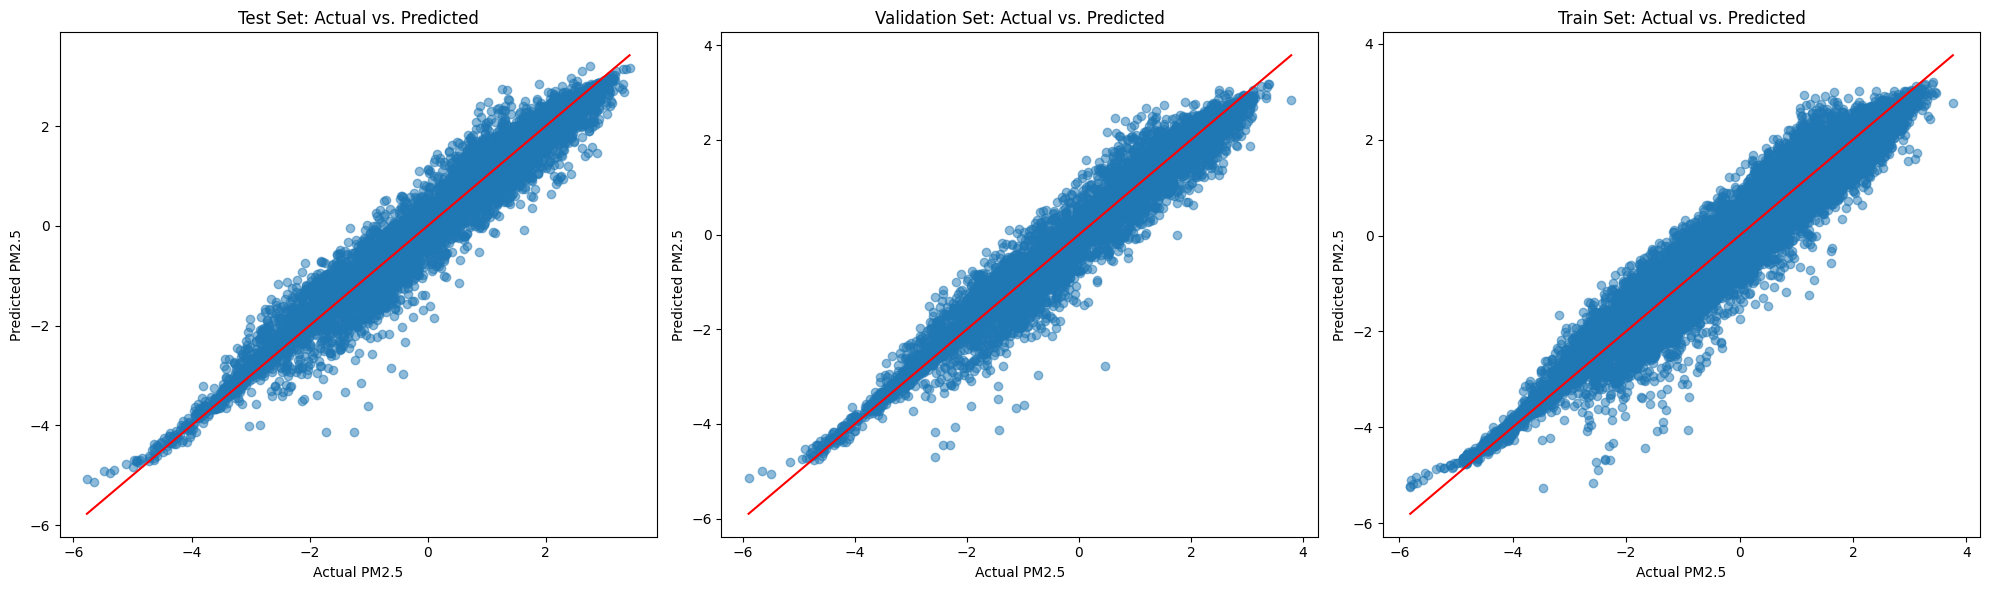

In [ ]:
metrics_pca_5 = evaluate_model(model_pca_5, X_train, y_train, X_val, y_val, X_test, y_test)
# metrics_pca_5

In [ ]:
# resample_and_plot_predictions(model_pca_5, X_test, y_test)

#### Evaluating PCA = 6 model

In [ ]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)  # Transform the scaled data

# Generate sequences
df_LSTM_seq = create_sequences(X_pca, TIMESTEPS, DELAY)

# Split & standardize dataset
X_train, y_train, X_val, y_val, X_test, y_test = split_and_standardize(df_LSTM_seq, TIMESTEPS, DELAY)

In [ ]:
# Load the trained model
model_pca_6 = load_model(model_path + "lstm_7d_pca_6_forecast_pm25.keras")

# Load Training History
with open(model_path + "lstm_7d_pca_6_forecast_pm25_training_history.json", "r") as f:
    history_dict = json.load(f)

# Print summary to confirm it loaded correctly
model_pca_6.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 168, 32)             │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 168, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 168, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 168, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,997 (253.90 KB)

 Trainable params: 21,665 (84.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,332 (169.27 KB)

In [ ]:
# Get Number of Epochs Run
num_epochs = len(history_dict["loss"])
print(f"Total epochs run: {num_epochs}")

Total epochs run: 62


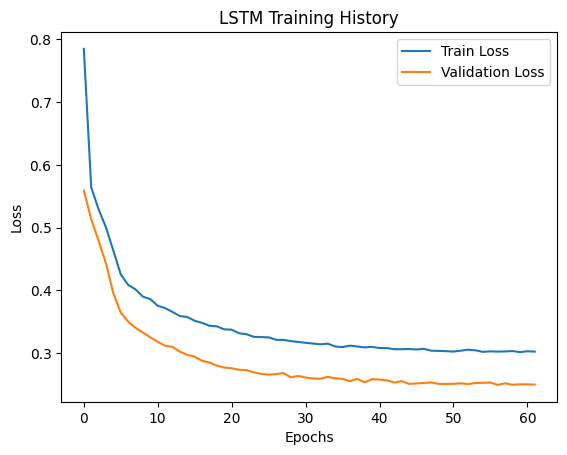

In [ ]:
plt.plot(history_dict["loss"], label="Train Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM Training History")
plt.show()

818/818 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step


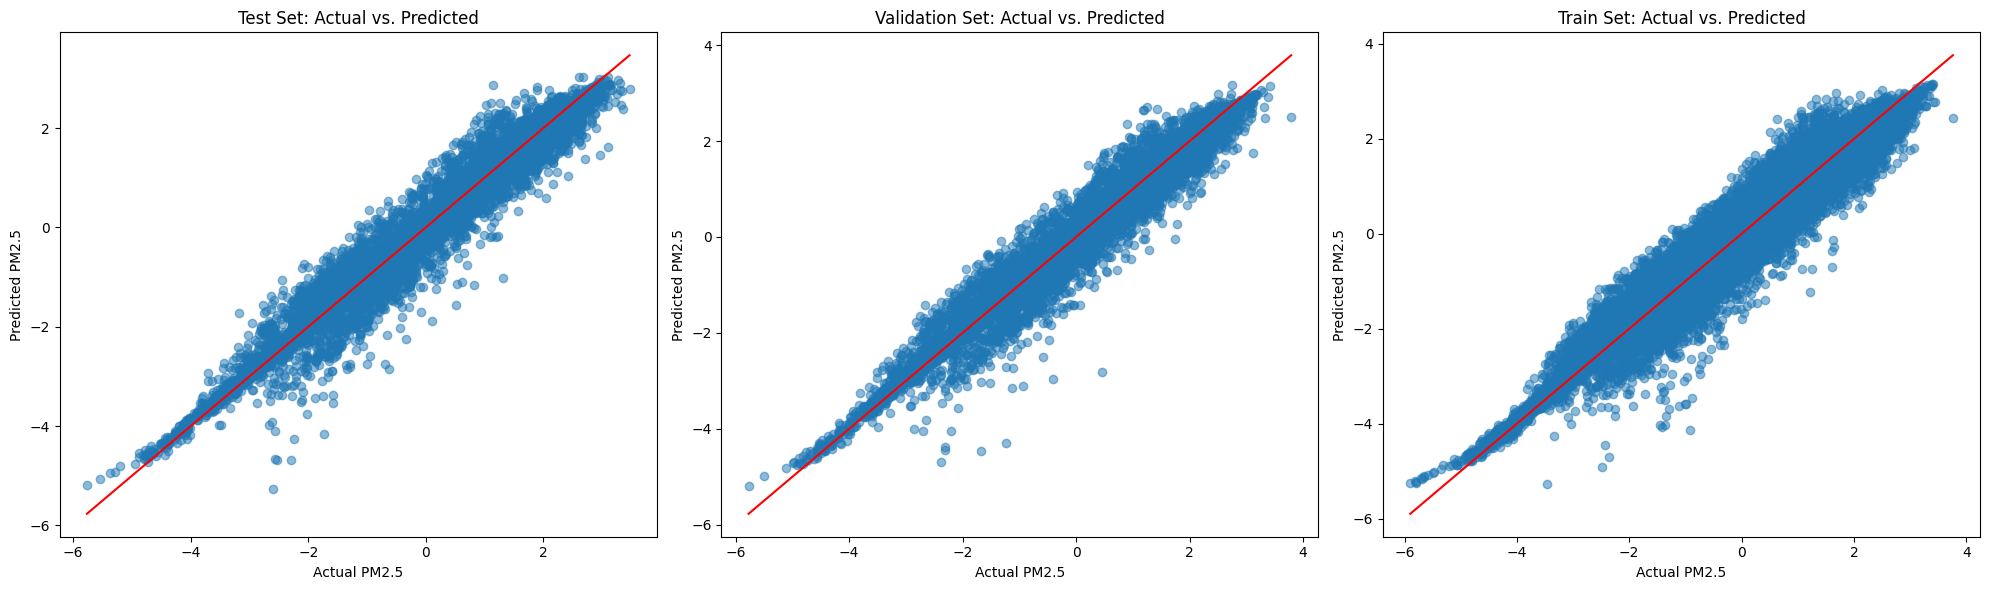

In [ ]:
metrics_pca_6 = evaluate_model(model_pca_6, X_train, y_train, X_val, y_val, X_test, y_test)
# metrics_pca_6

In [ ]:
# resample_and_plot_predictions(model_pca_6, X_test, y_test)

#### Evaluating PCA = 7 model

In [ ]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)  # Transform the scaled data

# Generate sequences
df_LSTM_seq = create_sequences(X_pca, TIMESTEPS, DELAY)

# Split & standardize dataset
X_train, y_train, X_val, y_val, X_test, y_test = split_and_standardize(df_LSTM_seq, TIMESTEPS, DELAY)

In [ ]:
# Load the trained model
model_pca_7 = load_model(model_path + "lstm_7d_pca_7_forecast_pm25.keras")

# Load Training History
with open(model_path + "lstm_7d_pca_7_forecast_pm25_training_history.json", "r") as f:
    history_dict = json.load(f)

# Print summary to confirm it loaded correctly
model_pca_7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 168, 32)             │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 168, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 168, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 168, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,381 (255.40 KB)

 Trainable params: 21,793 (85.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,588 (170.27 KB)

In [ ]:
# Get Number of Epochs Run
num_epochs = len(history_dict["loss"])
print(f"Total epochs run: {num_epochs}")

Total epochs run: 62


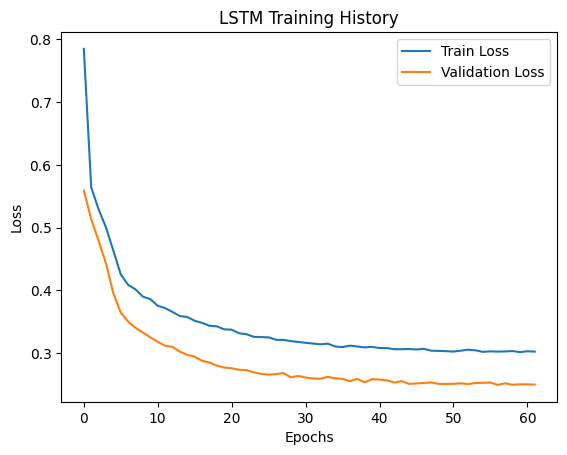

In [ ]:
plt.plot(history_dict["loss"], label="Train Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM Training History")
plt.show()

818/818 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step


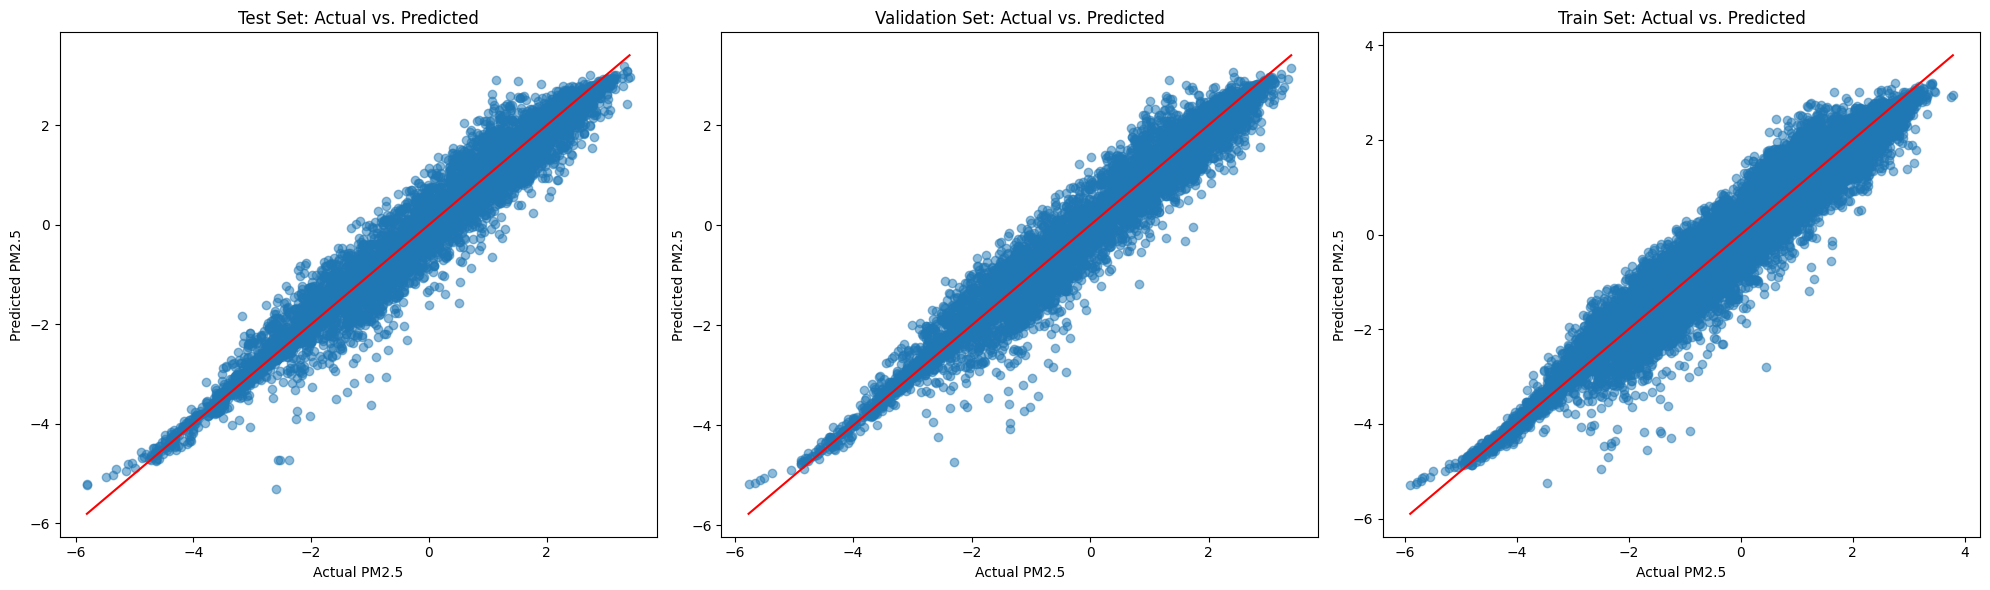

,Dataset,MAE,MSE,RMSE,R² Score
0,Training,0.244578,0.130703,0.361529,0.956946
1,Validation,0.253796,0.139770,0.373858,0.954034
2,Test,0.246094,0.131964,0.363268,0.957176


In [ ]:
metrics_pca_7 = evaluate_model(model_pca_7, X_train, y_train, X_val, y_val, X_test, y_test)
metrics_pca_7

#### Comparing metrics from the model with pca = 5, 6 and 7

In [ ]:
metrics_pca_5["Model"] = "PCA_5"
metrics_pca_6["Model"] = "PCA_6"
metrics_pca_7["Model"] = "PCA_7"

all_metrics = pd.concat([metrics_pca_5, metrics_pca_6,metrics_pca_7], ignore_index=True)
all_metrics

,Dataset,MAE,MSE,RMSE,R² Score,Model
0,Training,0.250315,0.134512,0.366759,0.955848,PCA_5
1,Validation,0.248182,0.132738,0.364333,0.956118,PCA_5
2,Test,0.249456,0.131331,0.362396,0.957156,PCA_5
3,Training,0.250888,0.135706,0.368382,0.955479,PCA_6
4,Validation,0.242393,0.128594,0.358600,0.957573,PCA_6
5,Test,0.246611,0.132976,0.364658,0.956446,PCA_6
6,Training,0.244578,0.130703,0.361529,0.956946,PCA_7
7,Validation,0.253796,0.139770,0.373858,0.954034,PCA_7
8,Test,0.246094,0.131964,0.363268,0.957176,PCA_7


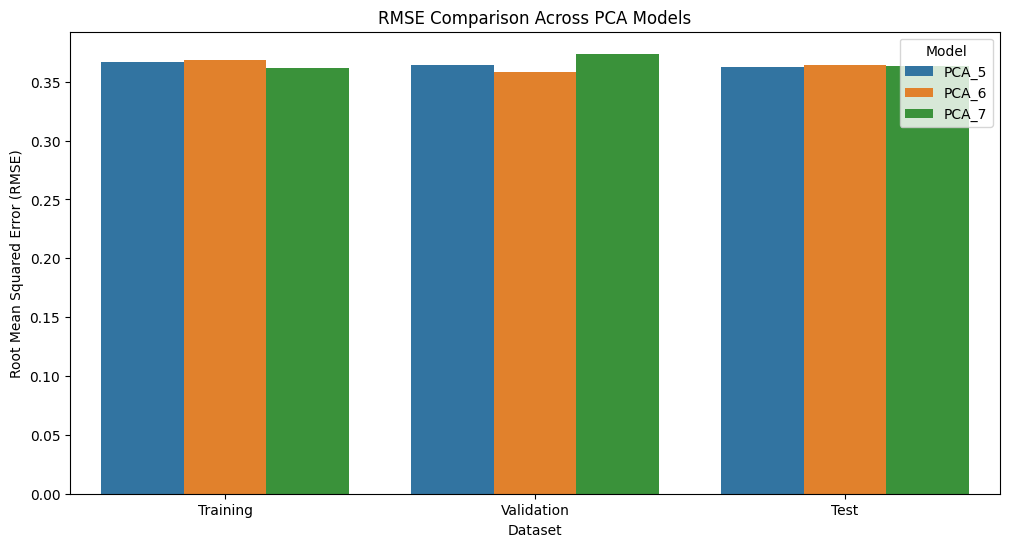

In [ ]:
# Melt the DataFrame for easier plotting
metrics_melted = all_metrics.melt(id_vars=["Model", "Dataset"], var_name="Metric", value_name="Value")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Dataset", y="Value", hue="Model", data=metrics_melted[metrics_melted["Metric"] == "RMSE"])

plt.title("RMSE Comparison Across PCA Models")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xlabel("Dataset")
plt.legend(title="Model")
plt.show()


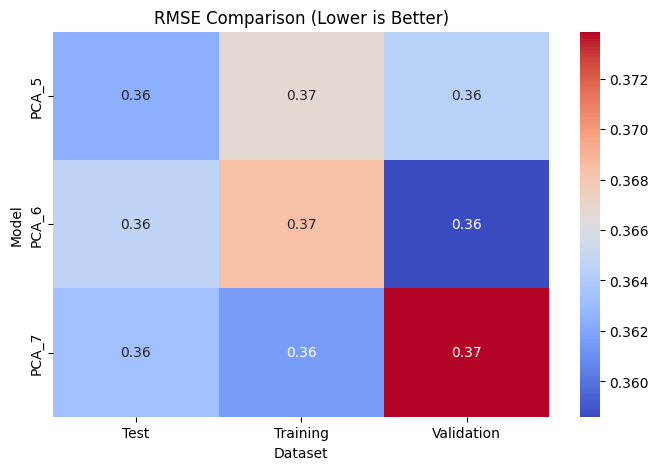

In [ ]:
plt.figure(figsize=(8, 5))
pivot_table = all_metrics.pivot(index="Model", columns="Dataset", values="RMSE")
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f")

plt.title("RMSE Comparison (Lower is Better)")
plt.xlabel("Dataset")
plt.ylabel("Model")
plt.show()

## Comparison of LSTM with pca and without pca

In [ ]:
metrics_without_pca["Model"] = "No PCA"
metrics_pca_6["Model"] = "PCA"

all_metrics = pd.concat([metrics_without_pca, metrics_pca_6], ignore_index=True)
all_metrics

,Dataset,MAE,MSE,RMSE,R² Score,Model
0,Training,0.914604,1.866523,1.366208,0.990980,No PCA
1,Validation,0.919882,1.875834,1.369611,0.990977,No PCA
2,Test,0.911046,1.913522,1.383301,0.990742,No PCA
3,Training,0.250888,0.135706,0.368382,0.955479,PCA
4,Validation,0.242393,0.128594,0.358600,0.957573,PCA
5,Test,0.246611,0.132976,0.364658,0.956446,PCA


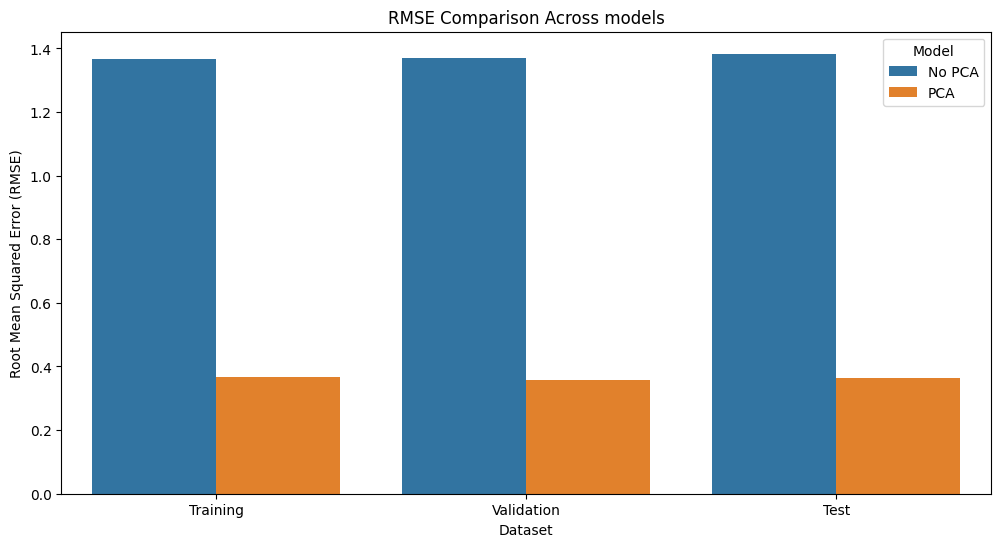

In [ ]:
# Melt the DataFrame for easier plotting
metrics_melted = all_metrics.melt(id_vars=["Model", "Dataset"], var_name="Metric", value_name="Value")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Dataset", y="Value", hue="Model", data=metrics_melted[metrics_melted["Metric"] == "RMSE"])

plt.title("RMSE Comparison Across models")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xlabel("Dataset")
plt.legend(title="Model")
plt.show()


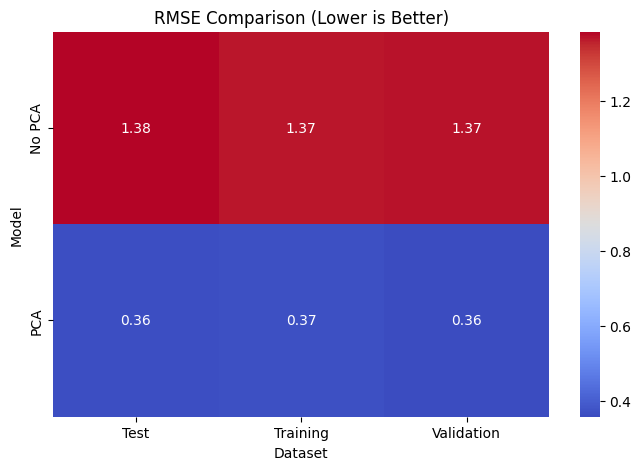

In [ ]:
plt.figure(figsize=(8, 5))
pivot_table = all_metrics.pivot(index="Model", columns="Dataset", values="RMSE")
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f")

plt.title("RMSE Comparison (Lower is Better)")
plt.xlabel("Dataset")
plt.ylabel("Model")
plt.show()

## PCA + ARIMA + LSTM for sequential data

In [ ]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)  # Transform the scaled data

# Generate sequences
df_LSTM_seq = create_sequences(X_pca, TIMESTEPS, DELAY)

# Split & standardize dataset
X_train, y_train, X_val, y_val, X_test, y_test = split_and_standardize(df_LSTM_seq, TIMESTEPS, DELAY)

model_name = f"ARIMA_LSTM_forecast_pm25"
model_hybrid, history_hybrid = train_hybrid_arima_lstm(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    model_name=model_name,
    epochs=100,
    batch_size=128
)

In [ ]:
# Load the trained model
model_ARIMA = load_model(model_path + "ARIMA_LSTM_forecast_pm25.keras")

# Load Training History
with open(model_path+"ARIMA_LSTM_forecast_pm25_training_history.json", "r") as f:
    history_dict = json.load(f)

# Print summary to confirm it loaded correctly
model_ARIMA.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 168, 64)             │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 168, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 168, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 168, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,869 (987.77 KB)

 Trainable params: 84,289 (329.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 168,580 (658.52 KB)

In [ ]:
# Get Number of Epochs Run
num_epochs = len(history_dict["loss"])
print(f"Total epochs run: {num_epochs}")

Total epochs run: 100


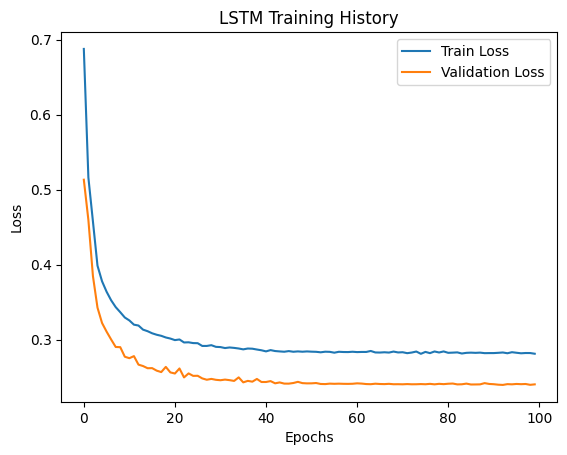

In [ ]:
plt.plot(history_dict["loss"], label="Train Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM Training History")
plt.show()

818/818 ━━━━━━━━━━━━━━━━━━━━ 66s 79ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step


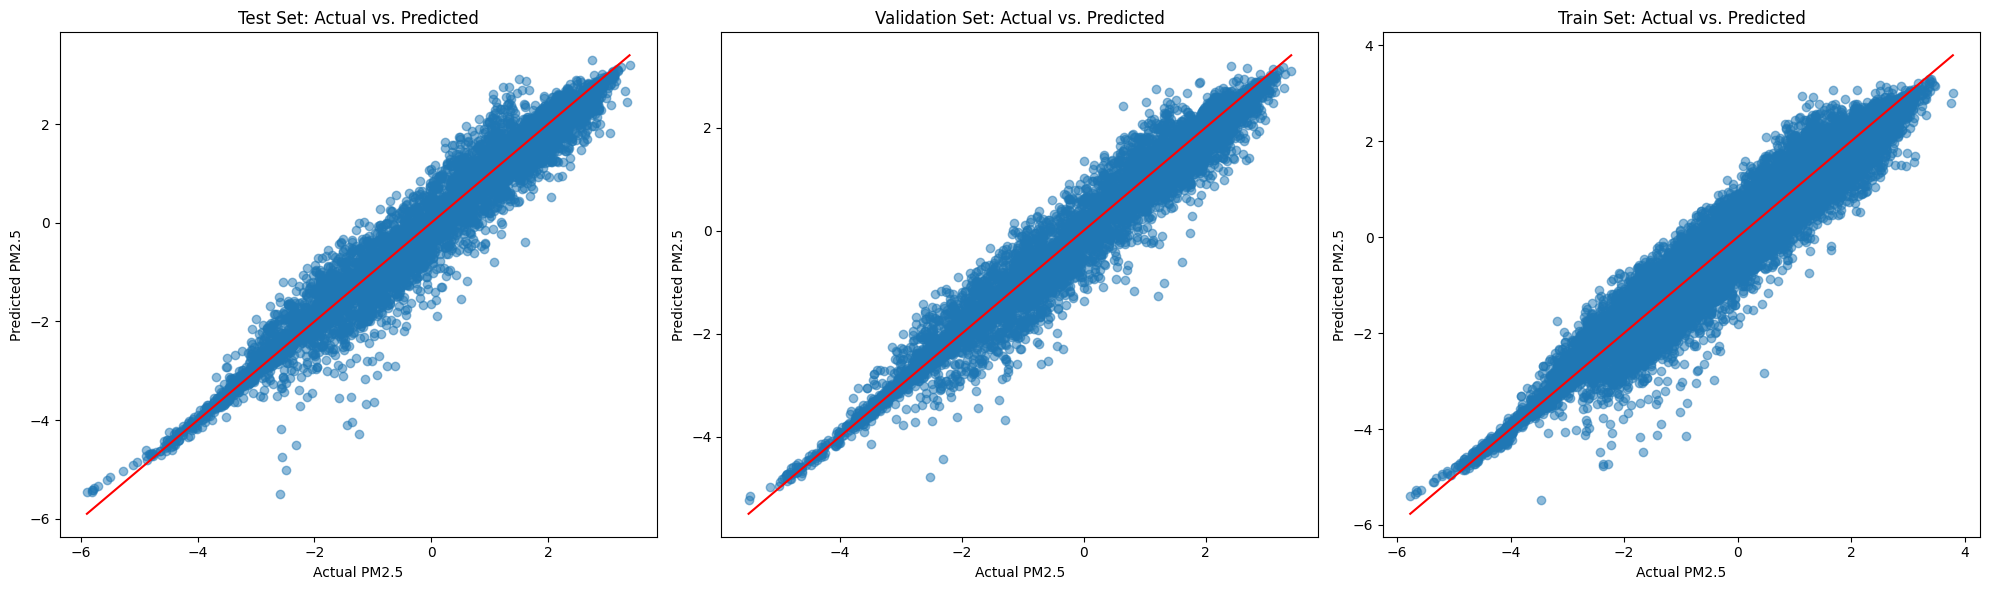

In [ ]:
metrics_model_ARIMA = evaluate_model(model_ARIMA, X_train, y_train, X_val, y_val, X_test, y_test)
# metrics_model_ARIMA

In [ ]:
metrics_model_ARIMA["Model"] = "PCA-ARIMA-LSTM"
metrics_pca_6["Model"] = "PCA-LSTM"

all_metrics = pd.concat([metrics_model_ARIMA, metrics_pca_6], ignore_index=True)
all_metrics

,Dataset,MAE,MSE,RMSE,R² Score,Model
0,Training,0.241148,0.131958,0.363260,0.956411,PCA-ARIMA-LSTM
1,Validation,0.239715,0.128463,0.358418,0.958025,PCA-ARIMA-LSTM
2,Test,0.247276,0.140063,0.374250,0.954627,PCA-ARIMA-LSTM
3,Training,0.250888,0.135706,0.368382,0.955479,PCA-LSTM
4,Validation,0.242393,0.128594,0.358600,0.957573,PCA-LSTM
5,Test,0.246611,0.132976,0.364658,0.956446,PCA-LSTM


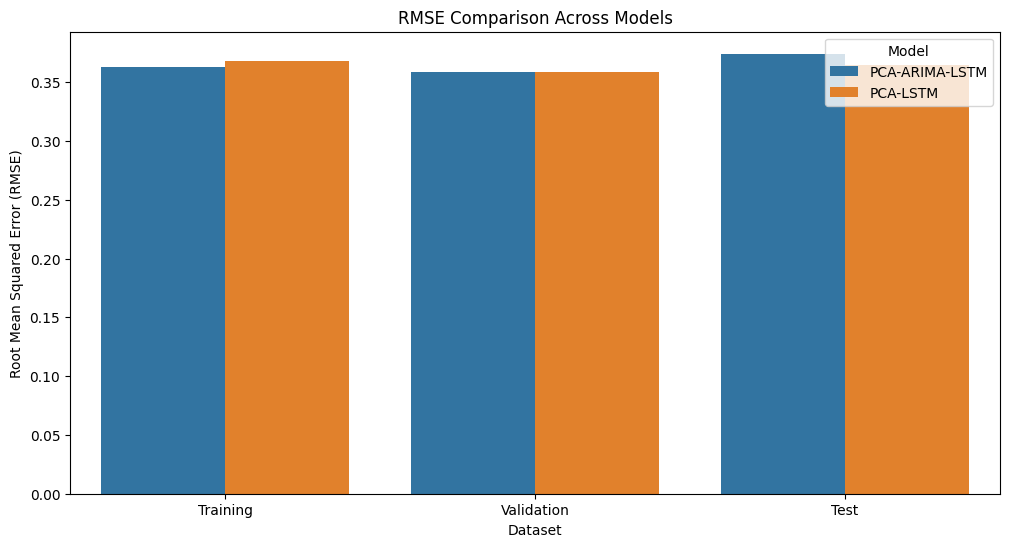

In [ ]:
# Melt the DataFrame for easier plotting
metrics_melted = all_metrics.melt(id_vars=["Model", "Dataset"], var_name="Metric", value_name="Value")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Dataset", y="Value", hue="Model", data=metrics_melted[metrics_melted["Metric"] == "RMSE"])

plt.title("RMSE Comparison Across Models")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xlabel("Dataset")
plt.legend(title="Model")
plt.show()

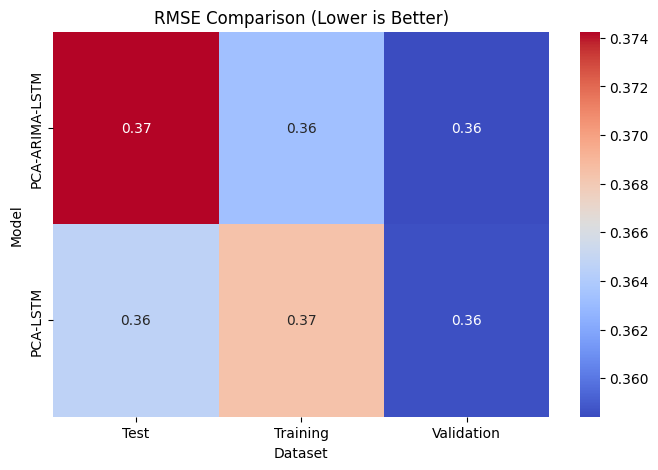

In [ ]:
plt.figure(figsize=(8, 5))
pivot_table = all_metrics.pivot(index="Model", columns="Dataset", values="RMSE")
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f")

plt.title("RMSE Comparison (Lower is Better)")
plt.xlabel("Dataset")
plt.ylabel("Model")
plt.show()

273/273 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step


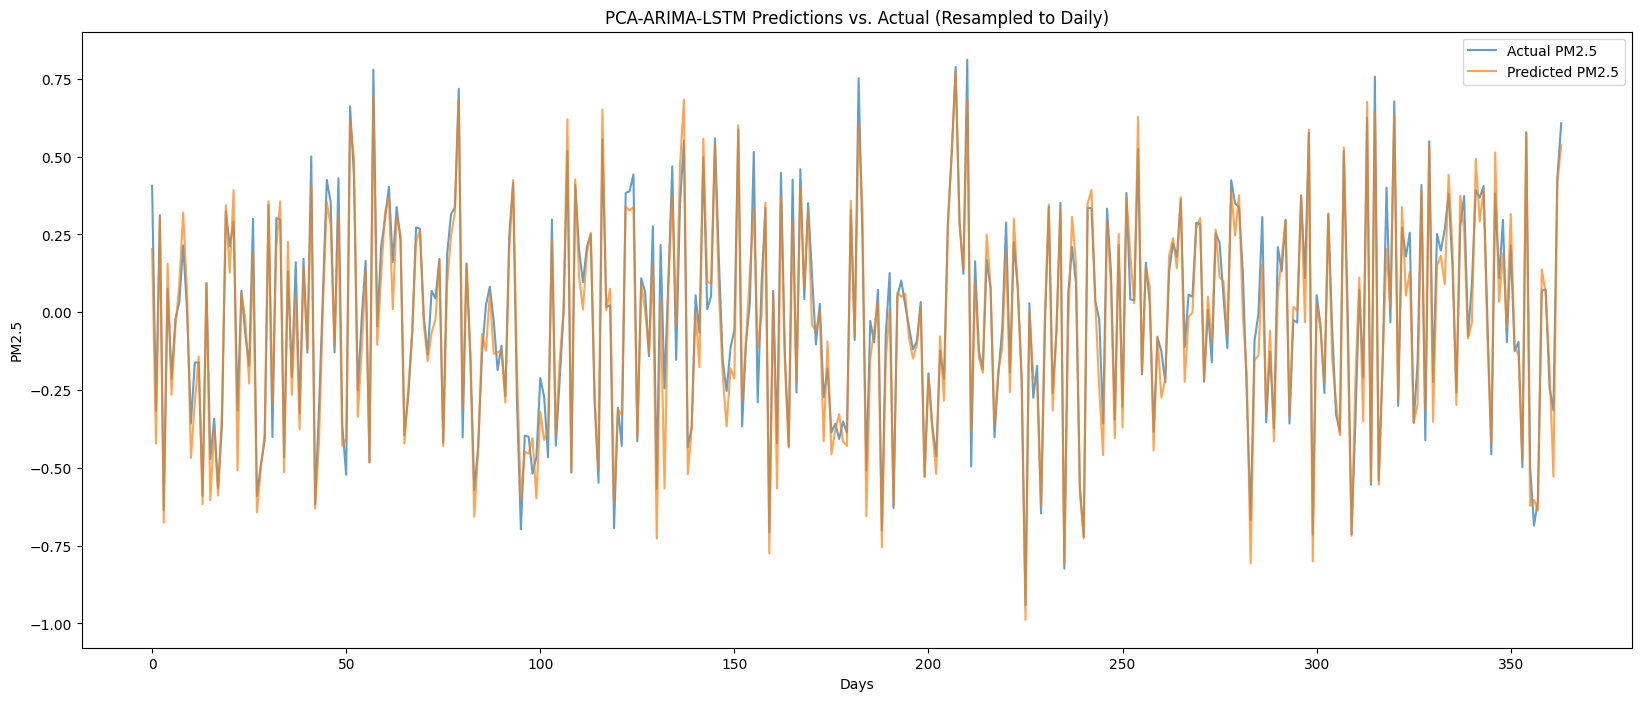

In [ ]:
resample_and_plot_predictions(model_ARIMA, X_test, y_test)